In this series, I want to discuss the creation of a small library for training neural networks: `nntrain`. It's based off the excellent [part 2](https://course.fast.ai/) of Practical Deep Learning for Coders by Jeremy Howard, in which from lessons 13 to 18 (roughly) the development of the `miniai` library is discussed.

The library will build upon PyTorch. We'll try as much as possible to build from scratch to understand how it all works. Once the main functionality of components are implemented and verified, we can switch over to PyTorch's version. This is similar to how things are done in the course. However, this is not just a "copy / paste" of the course: on many occasions I take a different route, and most of the code is my own. That is not to say that all of this is meant to be extremely innovative, instead I had the following goals:

- Deeply understand the training of neural networks with a focus on PyTorch
- Try to create an even better narrative then what's presented in FastAI 🙉🤷‍♂️🙈
- Get hands-on experience with creating a library with [`nb_dev`](https://nbdev.fast.ai/)

`nb_dev` is another great project from the fastai community, which allows python libraries to be written in jupyter notebooks. This may sound a bit weird since the mainstream paradigm is to only do experimental work in notebooks. It has the advantage though that we can create the source code for our library in the very same environment in which we want to experiment and interact with our methods, objects and structure **while we are building the library**. For more details on why this is a good idea and other nice features of `nb_dev`, see [here](https://www.fast.ai/posts/2022-07-28-nbdev2.html).

So without further ado, let's start with where we left off in the previous [post](https://lucasvw.github.io/posts/11_nntrain_activations/):

## End of last post:

In the last [post](https://lucasvw.github.io/posts/11_nntrain_activations/) we build a convolutional neural network, loaded the Fashion-Mnist data using our [Dataloaders](https://lucasvw.github.io/nntrain/dataloaders.html) module, and trained it using the [Learner](https://lucasvw.github.io/nntrain/learner.html) module. We created a [module](https://lucasvw.github.io/nntrain/activations.html) which helped to understand the fine-print of training a model, more specifically by understanding the activations throughout the network during training. 

We finally reached a performance of around 89% (evaluation) accuracy by training 5 epochs. In this post, we are going to look closely into how a model is learning: the step in which we update the weights after the backward pass in the training loop.

Updating the weights takes the form of:


$$
w_t = w_{t-1} - lr \cdot grad^{w}_{t-1}
$$
or in more pseudocode style syntax:
$$
w \leftarrow w - lr \cdot grad^{w}
$$

Before we dive into different versions of this update step and it's implications, I would like to have a good look at this remarkebly simple formula. Specifically, it's important that the change to the weights from one step to another is composed of the product of the learning rate $lr$ and the gradient of the loss with respect to the weight we are updating: $grad^w$. And since it's a product, doubling one and reducing the other by a factor of 2, cancel each other out. 

For example, consider some training setup with some loss function $loss$ and some learning rate $lr$. If we would change our loss function by adding a factor of 2: $loss_1 = 2 \cdot loss$ this would have the effect that the gradients would also double. Very similiar to how if 

\begin{aligned}
f(x) &= x^2 &&\rightarrow f'(x) = 2x \\
g(x) &= 2f(x) = 2x^2  &&\rightarrow g'(x) = 4x = 2f'(x)
\end{aligned}


And since learning rate and gradients are multiplied in the weight update, we could offset the doubling of the loss by reducing the learning rate by 2. It's thus important to realize how these components interact.

## Weight decay

Weight decay is a very common regularization technique. Regularization is meant to reduce overfitting. When a model is overfitting, it basically has learned the structure of the training set to such a degree (e.g. memorized) that it performs very well on the training set, but performance is degraded on the validation set. This means the model is no longer generalizing well to data it was not trained on. And since we are always interested in using a model for making predictions on data it hasn't seen (e.g. inference), this is an extremely important thing to be aware of.

Weight decay takes the simple form of adding a component to the loss which penalizes large weights:

$$
loss_{wd} = loss + c\sum{w_i^2}
$$

And since this simple sum we are adding has no interaction terms between weights, we simply get:

\begin{aligned}
grad_{wd} &= grad + 2c\cdot w \\ 
&= grad + d \cdot w
\end{aligned}

And then going back to updating the weights:


\begin{aligned}
w_{wd} &\leftarrow w_{wd} - lr \cdot grad_{wd}  \\
&= w_{wd} - lr \cdot (grad + d \cdot w_{wd}) \\
&= w_{wd} - lr \cdot grad - lr \cdot d \cdot w_{wd} \\
&= w_{wd}(1 - lr \cdot d) - lr \cdot grad 
\end{aligned}

If we compare this expression to the regular update step: $w \leftarrow w - lr \cdot grad^{w}$, we find that we can simply multiply the weights by $(1 - lr \cdot d)$ before we do the step:

In [ ]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        self.params = list(params)
        self.lr = lr
        self.wd = wd
        self.i = 0

    def step(self):                    # this is the method that get's called by the Learner
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)       # first add regularization
                self.opt_step(p)       # then do the actual step
        self.i +=1

    def opt_step(self, p):
        p -= p.grad * self.lr          # regular step
    
    def reg_step(self, p):
        if self.wd != 0:               # only regularize when the weight decay parameter is set
            p *= 1 - self.lr*self.wd   # update the weights as described above

    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

Let's try it out:

In [ ]:
#|code-fold: true
from datasets import load_dataset,load_dataset_builder

from nntrain.dataloaders import DataLoaders, hf_ds_collate_fn
from nntrain.learner import *
from nntrain.activations import *

In [ ]:
#|code-fold: true
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import torch.nn.functional as F
from operator import attrgetter
from functools import partial
import fastcore.all as fc
import math
import torcheval.metrics as tem
import matplotlib.pyplot as plt
import random
import numpy as np

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

epoch,mode,loss,accuracy
0,train,0.591,0.788
0,eval,0.420,0.840
1,train,0.349,0.873
1,eval,0.364,0.863
2,train,0.304,0.889
2,eval,0.344,0.873
3,train,0.279,0.897
3,eval,0.325,0.883
4,train,0.259,0.904
4,eval,0.305,0.888


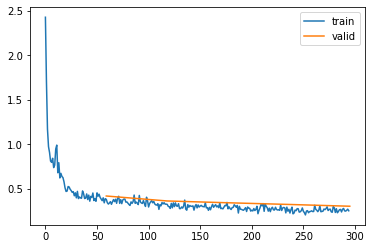

In [ ]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
hf_dd = load_dataset(name)
bs = 1024
collate = partial(hf_ds_collate_fn, flatten=False)
dls = DataLoaders.from_hf_dd(hf_dd, batch_size=bs, collate_fn=collate)
set_seed(1)

# model and initializaton
model = cnn_layers().apply(init_weights)

# normalization
xb, yb = next(iter(dls.train))
norm = NormalizationS(xb.mean(), xb.std())

# subscribers
subs = [norm, 
        ProgressS(True),
        MetricsS(accuracy=tem.MulticlassAccuracy()),
        DeviceS(device)]

# Remember that the optim_func get's initialized during fit()
# https://github.com/lucasvw/nntrain/blob/main/nntrain/learners.py#L53C65-L53C65
optim_func = partial(SGD, wd=0)

l = MomentumLearner(model, dls, F.cross_entropy, optim_func, 0.4, subs)
l.fit(5)

## Momentum

Momentum has to do with smartly navigating the loss surface. The loss surface is a high dimensional plain (manifold) where each dimension is a single parameter in the model. Since humans are not made for thinking beyond 3 dimensions, let's thus quickly replace this by a mental image with just 3 dimensions. Let the loss surface have just 2 parameters that are put on the x and y dimensions, and let z represent the value of our loss function. 

Training a neural network is all about finding a low (the lowest) spot on this surface, e.g. a point in this space in which the parameters (x and y) take on a value so that the loss (z direction) is low.

To find such a spot, we have to navigate this surface. Sometimes it might be difficult to find this spot from the point where we are, since the lowest value might lay behind a hill. Realize that we also never "see" the complete surface, we can only navigate it by computing gradients from the point where we currently are. We can draw an analogy of a astronaut being dropped in a completely alien world, having a need to find water (the lowest point on the surface) as quickly as possible (because of limitted oxygen supply) with a visibility of only 1 meter.

![hello](loss_surface.png)

So what's our strategy to find water asap? With SGD we compute the gradient based on the contributions of each sample in the minibatch. Then we take a small step in this direction (of size: learning rate * gradient). And we keep repeating this. But imagine that each time we compute this gradient, we find that it's more or less in the same direction. Would it then not make sense to maybe take a bit of a larger step? This is the intuition behind momentum, don't just consider the gradient at the current position, but get some sense of the surrounding surface by inferring from the past couple of computed gradients. The following image shows this also nicely:

![mom](momentum.png){width=300}

To implement, we simply do:

\begin{aligned}
w &\leftarrow w - lr \cdot grad\_avg
\end{aligned}

The way $grad\_avg$ is computed, takes different forms. In PyTorch SGD it's simply:

$$
grad\_avg \leftarrow grad + \mu \cdot grad\_avg
$$

And this is also exactly the way we previously implemented in the [`MomentumLearner`](https://lucasvw.github.io/posts/10_nntrain_learner/#momentumlearner). Additionally PyTorch defines a dampening parameter $\tau$ (defaulting to zero):

$$
grad\_avg \leftarrow (1 - \tau) grad + \mu \cdot grad\_avg
$$


In FastAI, we take a weighted average between the grad and the average:

$$
grad\_avg \leftarrow (1-c) grad + c \cdot grad\_avg
$$

So FastAI's version is equivalent to setting $\tau = \mu$ (dampening = momentum)


In [ ]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom=mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -= self.lr * p.grad_avg

epoch,mode,loss,accuracy
0,train,0.607,0.784
0,eval,0.440,0.839
1,train,0.360,0.869
1,eval,0.372,0.861
2,train,0.323,0.882
2,eval,0.363,0.867
3,train,0.295,0.892
3,eval,0.332,0.877
4,train,0.271,0.901
4,eval,0.312,0.885


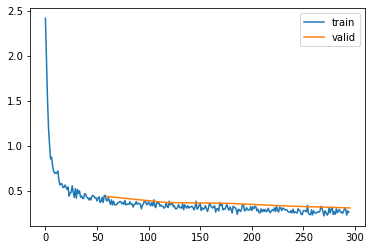

In [ ]:
set_seed(1)

model = cnn_layers().apply(init_weights)

subs = [norm, 
        ProgressS(True),
        MetricsS(accuracy=tem.MulticlassAccuracy()),
        DeviceS(device)]

optim_func = Momentum

l = Learner(model, dls, F.cross_entropy, optim_func, 1.5, subs)
l.fit(5)

Geoffrey Hinton in his [lecture](https://youtu.be/z2rTn8Evav8?si=Sd6surVPoo1c7pr8) on Momentum mentions that one problem with using a large learning rate with plain SGD is that you can get divergent oscillations if you try to travel down a long and narrow ravene, similar to what would happen with an even larger learning rate (larger step) on the left hand picture above showing "SGD without Momentum". Now by adding momentum, it's easier to find the "dominant" direction and we can thus increase the learning rate without causing divergent oscillations. 

One issue he describes, is that in the beginning of training when the gradients are still large, the momentum should be kept much smaller since otherwise the updates become just too big. One way to deal with these would be to change the momentum during training (but more about that later when we start looking into schedulers) or by using something like RMSProp:

## RMSProp

RMSProp is a technique (first?) described by Geoffrey Hinton in an online [MOOC](https://www.youtube.com/watch?v=XhZahXzEuNo). In FastAI RMSProp is described as "Momentum, but with the squares of the gradient". I personally think this is a rather bad explanation, since this is **not at all** what's going on. Instead it's a technique that is concerned with different weights and the difference in magnitude of their gradients. This leads to weights getting updated at very different "speeds". E.g. if you have one weight which gradient is 10 times the gradient of another, that weight get's an update that's 10 times as large as the other one. This can exist between weights at one single step, but also between gradients of a single weight during different times in training. The reason for this is ofcourse that the learning rate is equal **at all times for all parameters**. RMSProp is a technique which scales the gradients inversely to the (averaged out) magnitude of the gradient:

$$
w \leftarrow w - lr \cdot \frac{grad}{\sqrt{acc\_sqrd\_grad}}
$$

where 

$$
acc\_sqrd\_grad = c \cdot acc\_sqrd\_grad + (1-c) grad^2
$$


From this, it should be clear that using this technique, has a large impact on the weight updates and means you have to re-set your learning rate.

In [ ]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom = sqr_mom
        self.eps = eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): 
            p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg*self.sqr_mom + (1-self.sqr_mom)*p.grad**2
        p -= self.lr * p.grad/(p.sqr_avg.sqrt() + self.eps)

epoch,mode,loss,accuracy
0,train,0.699,0.754
0,eval,0.473,0.829
1,train,0.421,0.847
1,eval,0.453,0.837
2,train,0.373,0.862
2,eval,0.387,0.858
3,train,0.344,0.874
3,eval,0.375,0.862
4,train,0.322,0.881
4,eval,0.350,0.874


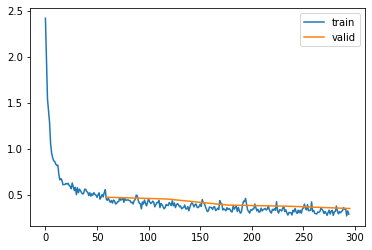

In [ ]:
set_seed(1)

model = cnn_layers().apply(init_weights)

subs = [norm, 
        ProgressS(True),
        MetricsS(accuracy=tem.MulticlassAccuracy()),
        DeviceS(device)]

optim_func = RMSProp

l = Learner(model, dls, F.cross_entropy, optim_func, 3e-3, subs)
l.fit(5)

## Adam

Adam is probably the most common optimizer used in practice, and is nothing more then the combination of RMSProp and Momentum:

$$
w \leftarrow w - lr \cdot \frac{avg\_grad}{\sqrt{acc\_sqrd\_grad}}
$$


In [ ]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): 
            p.avg = torch.zeros_like(p.grad.data)
            p.sqr_avg = torch.zeros_like(p.grad.data)
            
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

epoch,mode,loss,accuracy
0,train,0.609,0.783
0,eval,0.450,0.837
1,train,0.366,0.866
1,eval,0.371,0.867
2,train,0.319,0.882
2,eval,0.357,0.869
3,train,0.289,0.893
3,eval,0.326,0.881
4,train,0.269,0.902
4,eval,0.322,0.882


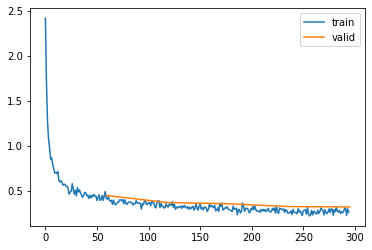

In [ ]:
set_seed(1)

model = cnn_layers().apply(init_weights)

subs = [norm, 
        ProgressS(True),
        MetricsS(accuracy=tem.MulticlassAccuracy()),
        DeviceS(device)]

optim_func = Adam

l = Learner(model, dls, F.cross_entropy, optim_func, 6e-3, subs)
l.fit(5)

## Learning Rate Schedulers

Now let's look at learning rate schedulers: these are objects that change important parameters such as the learning rate and momentum **during training**. The `OneCycleLR` scheduler for example starts with a low learning rate, then increases it to a maximum value and then anneales it back to the lower value. The idea being that initially, when our weights are random, we don't want to take too large steps. As the weights are getting somewhat reasonable, we speed up the learning and once we arrive at a better solution because of this, we decrease the learning rate again to make sure we can squeeze out the last bit of performance gain:

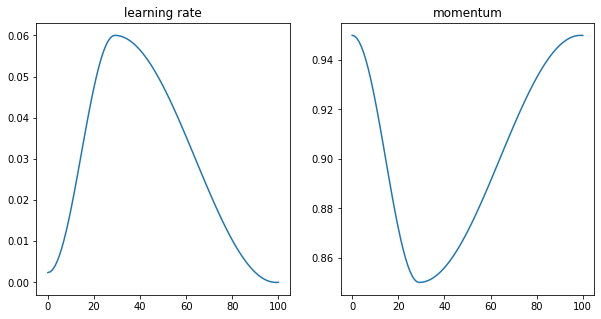

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=3e-3)

# Every scheduler has the concept of steps. 
# Either specified as done here or as "epochs" and "steps_per_epoch" (=# of batches) as two separate args
steps = 100   
sch = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=6e-2, total_steps=steps)

# The scheduler has a convenience method for getting the current learning rate
lrs = [sch.get_last_lr()]
# For other parameters such as momentum, we have to look into the optimizer itself
moms = [opt.param_groups[0]['momentum']]
for i in range(100):
    opt.step()                 
    sch.step()                       # calling step() on the scheduler updates the parameters of the optimizer
    lrs.append(sch.get_last_lr())
    moms.append(opt.param_groups[0]['momentum'])

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(lrs);
axs[0].set_title('learning rate');
axs[1].plot(moms);
axs[1].set_title('momentum');

Besides the cycling of the learning rate, the momentum is cycled inversely with the `OneCycleLr` scheduler

Let's see if we can create a Subscriber that enables the use of Schedulers in our framework:

In [ ]:
class SchedulerSubscriber(Subscriber):
    def __init__(self, scheduler_class):
        self.scheduler_class = scheduler_class
    
    # intialize the scheduler instance after the optimizer has been intialized
    def before_fit(self, learn):
        self.scheduler = self.scheduler_class(learn.opt) 
        
    # step the scheduler after the optimizer has stepped
    def after_step(self, learn):
        self.scheduler.step()

epoch,mode,loss,accuracy
0,train,0.678,0.762
0,eval,0.677,0.787
1,train,0.374,0.863
1,eval,0.363,0.865
2,train,0.298,0.890
2,eval,0.329,0.875
3,train,0.244,0.909
3,eval,0.274,0.896
4,train,0.206,0.924
4,eval,0.263,0.903


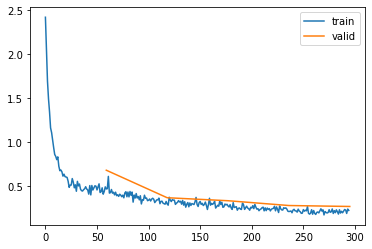

In [ ]:
set_seed(1)

model = cnn_layers().apply(init_weights)

epochs = 5
N = len(dls.train)

sch = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=6e-2, epochs=epochs, steps_per_epoch=N)

modules = [module for module in model.modules() if isinstance(module, nn.ReLU)]
act_stats = ActivationStatsS(modules)

subs = [norm, 
        act_stats,
        ProgressS(True),
        MetricsS(accuracy=tem.MulticlassAccuracy()),
        DeviceS(device), SchedulerSubscriber(sch)]

l = Learner(model, dls, F.cross_entropy, torch.optim.Adam, 6e-3, subs)
l.fit(epochs)

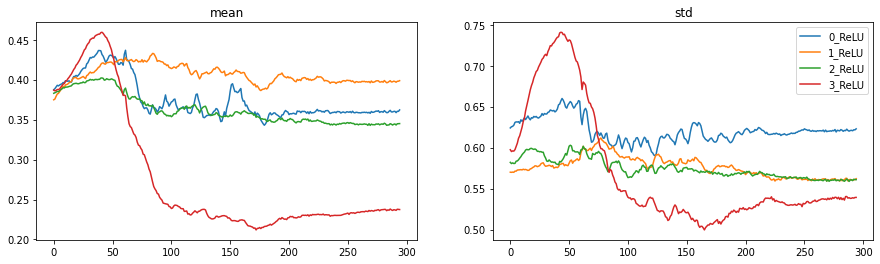

In [ ]:
act_stats.plot()

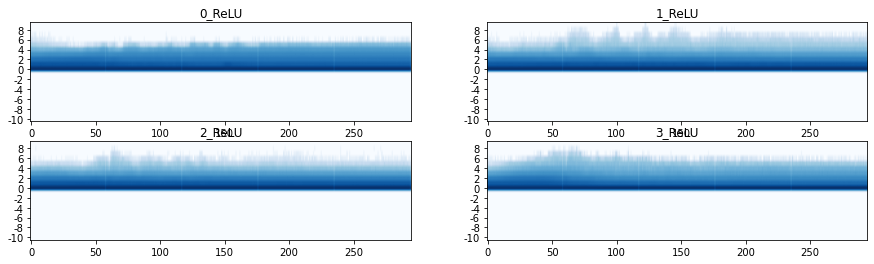

In [ ]:
act_stats.plot_hist()

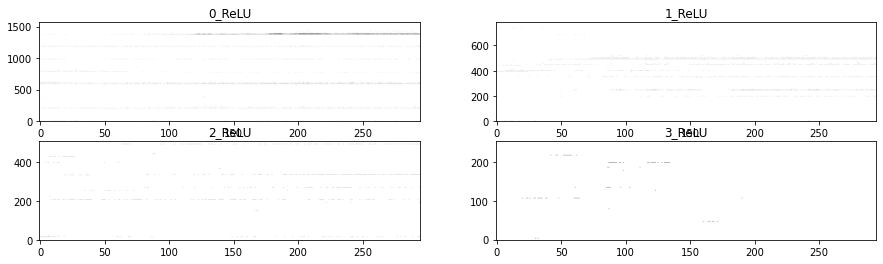

In [ ]:
act_stats.plot_dead(binary=True)

And that helps us to reach 90% accuracy! Not bad for a simple convolutional neural network

## ResNet

Next, let's have a look at improving the network itself:

epoch,mode,loss,accuracy
0,train,0.570,0.800
0,eval,0.628,0.812
1,train,0.321,0.881
1,eval,0.389,0.863
2,train,0.251,0.907
2,eval,0.335,0.876
3,train,0.198,0.927
3,eval,0.236,0.915
4,train,0.146,0.946
4,eval,0.230,0.918


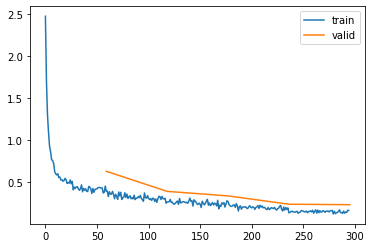

In [ ]:
def cnn_layers_2():
    return nn.Sequential(                               # 28x28  
        conv_block(1 , 8, stride=1),                    # 28x28
        conv_block(8 ,16),                              # 14x14
        conv_block(16,32),                              # 7x7
        conv_block(32,64),                              # 4x4
        conv_block(64,128),                             # 2x2
        conv_block(128,10, norm=False, act=False),      # 1x1
        nn.Flatten())

set_seed(1)

model = cnn_layers_2().apply(init_weights)

epochs = 5
N = len(dls.train)

sch = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=6e-2, epochs=epochs, steps_per_epoch=N)

modules = [module for module in model.modules() if isinstance(module, nn.ReLU)]
act_stats = ActivationStatsS(modules)

subs = [norm, 
        act_stats,
        ProgressS(True),
        MetricsS(accuracy=tem.MulticlassAccuracy()),
        DeviceS(device), SchedulerSubscriber(sch)]

l = Learner(model, dls, F.cross_entropy, torch.optim.Adam, 6e-3, subs)
l.fit(epochs)

The question arises whether we can keep increasing the depth of our model, to boost our performance. Since we already exhausted the pixel grid (we end up with a pixel grid of 1x1), the only way would be to add stride 1 convolutions which don't reduce the pixel-grid.

However, this doesn't improve performance. Kaiming et al found in "Deep Residual Learning for Image Recognition" that deeper CNN models often perform worse then shallow CNN models. They found this strange, since a deeper model can be understood as a superset of a more shallow model. It's easy to see this if we consider that a deeper model can just duplicate the shallow model in it's initial layers, and keep it's excess layers as an identity (so basically just passing through the data as is). But the observation they made, is that during training this "optimum" apparently is not found and the deeper model is performing worse then the shallow model.

This lead them to an architecture which should be able to *more easily* replicate the shallow network. And the way they did this, was by adding skip connections:

![skip connection](skip_connection.png){width=300}

So instead of having a fully sequential model, they added these identity skip connections (the arrow on th right) which connects both the input to and the ouput of a double convolutional layer. They argued that by doing so, it would be trivial for the model to forward the data without modifying it. This way the model can thus use the initial convolutional layers for the depth of "shallow" model, and use the skip connections for the layers that only the "deep" model has.

Why a double convolutional layer? For that we come back to the idea of adding stride 1 convolution to increase the depth of our model. In the architecture described above, the first convolutional layer is a stride 1 convolution (keeping the number of filters constant) and the second convolution is a stride 2 convolution thus reducing the pixel grid by 2.

The name for the block shown above is a ResBlock, and a model that is using them is called a ResNet. Res is short for residual, and that name becomes apparent when we look at this block in the following way:

\begin{aligned}
& y &&= x + conv_2(conv_1(x)) \\
& y - x &&= conv_2(conv_1(x)) \\
& residual &&= conv_2(conv_1(x))
\end{aligned}

The term $y-x$ is often called "the residual" in statistics. Now let's see how we can create such a ResBlock, we start with the convolutional connection:

In [ ]:
def conv_conn(in_c, out_c, kernel_size=3, stride=2):
    return nn.Sequential(
        conv_block(in_c, out_c, kernel_size=kernel_size, stride=1, act=True, norm=True),
        conv_block(out_c, out_c, kernel_size=kernel_size, stride=stride, act=False, norm=True)
    )

And let's create the ResBlock with a couple of notes upfront:

- We can only use a "true" identity connection (`y_id = x`) under the condition that the convolutions don't change the number of filters (`in_c = out_c`) nor the pixel grid (`stride=1`) (so basically the trailing 3 dimensions in our batch NCHW). If this is not the case, we have to "match up" the identity connection as *simple as possible* to these new dimension:
  - If the number of filters has changed we thus add a convolution with stride and kernel size equal to 1, only chaning the number of channels.
  - If the pixel grid has changed (halved in size due to a stride 2 convolution in the convolutional connection), we reduce the size of pixel grid in the same way, making use of a `AvgPool2d` layer, effectively averaging over a 2x2 kernel size.
- Note also that the second convolution doesn't have an activation, this is because we want to apply the activation after we add back the identity connection.

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=2):
        super().__init__()
        self.true_identity = in_c == out_c
        self.stride = stride
        self.conv_conn = conv_conn(in_c, out_c, stride=stride)
        self.identity_conn = conv_block(in_c, out_c, kernel_size=1, stride=1, act=False, norm=False)
        self.pooling = torch.nn.AvgPool2d(2, ceil_mode=True)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        y_conv = self.conv_conn(x)
        if self.true_identity: y_id = x
        elif self.stride == 1:
            y_id = self.identity_conn(x)
        else:
            y_id = self.pooling(self.identity_conn(x))
        return self.relu(y_conv + y_id)

Creating the ResNet is very similar to what we have done before, we basically replace the `conv_block` with a `ResBlock`. Additionally we add a linear layer at the end to map from the number of filters to our required categories (10).

In [ ]:
def resnet():
    return nn.Sequential(                             # pixel grid input: 28x28  
        ResBlock(1 , 8, stride=1),                    # 28x28
        ResBlock(8 ,16),                              # 14x14
        ResBlock(16,32),                              # 7x7
        ResBlock(32,64),                              # 4x4
        ResBlock(64,128),                             # 2x2
        ResBlock(128,256),                            # 1x1
        nn.Flatten(),                                 # flatten to 256 features
        nn.Linear(256, 10, bias=False),               # linear layer to map to 10 output features
        nn.BatchNorm1d(10)                            # final batchnorm layer
    )

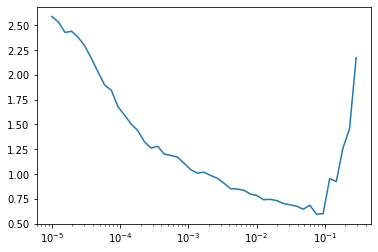

In [ ]:
set_seed(1)

model = resnet().apply(init_weights)

lrfind = LRFindS()

subs = [norm,
        DeviceS(device),
        lrfind]

l = Learner(model, dls, F.cross_entropy, torch.optim.Adam, 1e-5, subs=subs)
l.fit(1)

lrfind.plot()

epoch,mode,loss,accuracy
0,train,0.815,0.783
0,eval,0.558,0.850
1,train,0.399,0.889
1,eval,0.396,0.877
2,train,0.282,0.913
2,eval,0.312,0.900
3,train,0.213,0.934
3,eval,0.255,0.919
4,train,0.159,0.954
4,eval,0.237,0.928


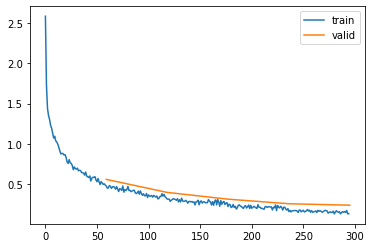

In [ ]:
set_seed(1)

model = resnet().apply(init_weights)

epochs = 5
N = len(dls.train)

lr = 1e-2

sch = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=N)

modules = [module for module in model.modules() if isinstance(module, nn.ReLU)]
act_stats = ActivationStatsS(modules)

subs = [norm, 
        act_stats,
        ProgressS(True),
        MetricsS(accuracy=tem.MulticlassAccuracy()),
        DeviceS(device), SchedulerSubscriber(sch)]

l = Learner(model, dls, F.cross_entropy, torch.optim.Adam, lr, subs)
l.fit(epochs)

Which reaches a score of almost 93% within 5 epochs!